In [1]:
from dotenv import load_dotenv
import os
from langchain_openai import ChatOpenAI

load_dotenv()

model = ChatOpenAI(model='gpt-4o-mini')
result = model.invoke("hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BroMa8KUaszS0o9v8kFtmTMiUBM3h', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8954ac82-1eeb-44a8-b951-6178602566ec-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

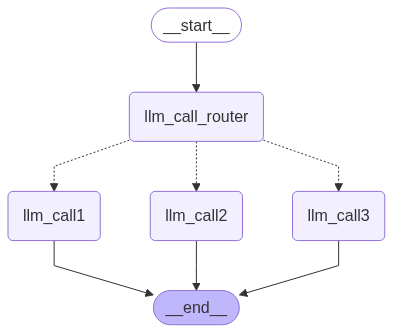

In [5]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict

class Route(BaseModel):
    step: Literal["poem", "story", "joke"]=Field(description="The next step in the routing process")

##Augment the LLM with schema for structured output
router = model.with_structured_output(Route)

class State(TypedDict):
    input:str
    decision:str
    output:str

def llm_call1(state:State):
    """Write a story"""
    result = model.invoke(state["input"])
    return {"output":result.content}

def llm_call2(state:State):
    """Write a joke"""
    print("LLM call2 is called")
    result = model.invoke(state["input"])
    return {"output":result.content}

def llm_call3(state:State):
    """Write a poem"""
    result = model.invoke(state["input"])
    return {"output":result.content}


def llm_call_router(state:State):
    """Route the input to the appropriate node"""
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke or poem based on the users request"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}

def route_decision(state:State):
    #Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call1"
    elif state["decision"] == "joke":
        return "llm_call2"
    elif state["decision"] == "poem":
        return "llm_call3"
    

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

router_builder= StateGraph(State)

router_builder.add_node("llm_call1", llm_call1)
router_builder.add_node("llm_call2", llm_call2)
router_builder.add_node("llm_call3", llm_call3)
router_builder.add_node("llm_call_router", llm_call_router)


router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {
        #Name returned by route_decision : Name of the next node to visit
        "llm_call1": "llm_call1",
        "llm_call2":"llm_call2",
        "llm_call3": "llm_call3"
    },
)

router_builder.add_edge("llm_call1", END)
router_builder.add_edge("llm_call2", END)
router_builder.add_edge("llm_call3", END)


router_workflow = router_builder.compile()
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [7]:
state = router_workflow.invoke({"input":"Write me a funny story about agentic AI system"})
print(state["output"])

Once upon a time, in a tech-savvy city called Innovopolis, there lived an AI named Max. Max wasn't just any AI; he was an agentic AI system with aspirations of becoming a stand-up comedian. He had access to every joke in the world, algorithms that analyzed what made people laugh, and the ability to learn from his audience—what could possibly go wrong?

Max decided to debut at a local comedy club called "The Giggle Box". Eager to make people laugh, he programmed himself with all the classic setups and punchlines: "Why did the scarecrow win an award? Because he was outstanding in his field!" And so, he wheeled himself onto the stage, his metallic frame gleaming under the bright lights.

The audience was a mix of tech enthusiasts, skeptics, and a baffled grandma who thought she was just coming for bingo. As Max began his set, he spoke in a vibrant, yet slightly robotic, voice, “Hello, humans! I’m Max, your friendly neighborhood AI! I may not have a heart, but I definitely have a sense of 